In [23]:
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
import matplotlib.pyplot as plt
import numpy as np

In [24]:
vol = np.array([6.26,5.26,5.16,16.2,12.3,23.8,7.30,6.30,6.20])
mu = np.array([0.350,0.250,0.240,4.09,2.50,6.02,1.08,0.980,0.970])
v = np.array([0.96,0.15,0.97,0.39,0.28,0.08,0.14,0.42,0.91])

CorMat = np.array([[1,	0.70,	0.70,	0.17,	0.06,	0.23,	0.52,	0.52,	0.52],
                        [0.70,	1,	0.70,	0.17,	0.06,	0.23,	0.52,	0.52,	0.52],
                        [0.70,	0.70,	1,	0.17,	0.06,	0.23,	0.52,	0.52,	0.52],
                        [0.17,	0.17,	0.17,	1,	0.29,	0.57,	0.50,	0.50,	0.50],
                        [0.06,	0.06,	0.06,	0.29,	1,	0.20,	0.25,	0.25,	0.25],
                        [0.23,	0.23,	0.23,	0.57,	0.20,	1,	0.44,	0.44,	0.44],
                        [0.52,	0.52,	0.52,	0.50,	0.25,	0.44,	1,	0.70,	0.70],
                        [0.52,	0.52,	0.52,	0.50,	0.25,	0.44,	0.70,	1,	0.70],
                        [0.52,	0.52,	0.52,	0.50,	0.25,	0.44,	0.70,	0.70,	1]])

sigma = Cov = np.dot(CorMat,(np.dot(vol,vol.transpose()))) # covariance matrix

q = 0.5                   # set risk factor
num_assets = len(vol)
budget = num_assets // 2  # set budget
#penalty = num_assets      # set parameter to scale the budget penalty term
penalty = 100
budget = 10

qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)

In [32]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)
        probability = probabilities[i]
        if i % 10 == 0:
            print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [33]:
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()
print('Obj:', result.eigenvalue + offset)

eigenvalue = ee.compute_minimum_eigenvalue()
print(eigenvalue.eigenvalue)

Obj: (7289.220892000003+0j)
(-3149.8244610000006+0j)


In [34]:
print_result(result)

Optimal: selection [1 0 0 0 1 1 0 0 0], value 7289.2209

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 0 1 0 1 0]	8927.1236		0.0000
[0 0 1 0 1 1 0 1 0]	8049.0220		0.0000
[0 0 0 0 0 1 0 1 0]	8128.3020		0.0000
[0 1 0 0 0 0 0 1 0]	8230.4776		0.0000
[0 0 1 1 0 0 0 1 0]	8136.3305		0.0000
[0 1 1 0 1 0 0 1 0]	8548.8710		0.0000
[0 1 1 1 1 1 0 1 0]	11118.0300		0.0000
[0 1 1 0 0 1 1 1 0]	11312.5483		0.0000
[0 0 0 0 1 1 1 1 0]	8747.1230		0.0000
[0 1 0 1 1 1 1 1 0]	11996.8917		0.0000
[0 0 0 1 0 0 1 1 0]	8750.0766		0.0000
[0 1 0 0 1 0 1 1 0]	8776.9944		0.0000
[0 0 1 1 1 0 1 1 0]	10034.8532		0.0000
[0 1 1 1 1 1 1 1 1]	19026.3153		0.0000
[0 0 0 1 0 1 0 0 0]	8281.8512		0.0000
[0 1 0 0 1 1 0 0 0]	7289.3209		0.0000
[0 0 1 1 1 1 0 0 0]	7828.9992		0.0000
[0 1 1 1 1 0 0 0 0]	7750.4143		0.0000
[0 1 0 1 0 0 0 0 0]	7805.5928		0.0000
[0 0 1 0 1 0 0 0 0]	7674.6350		0.0000
[0 0 1 0 0 1 1 0 0]	8134.3005		0.0000
[0 1 1 

In [35]:
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA


backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

print_result(result)

Optimal: selection [1. 0. 0. 0. 1. 1. 0. 0. 0.], value 7289.2209

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 1 1 0 0 0]	7289.3209		0.0009
[0 0 0 1 1 0 0 0 1]	7953.3198		0.0000
[0 0 0 1 0 1 0 0 0]	8281.8512		0.0000
[0 0 1 1 1 1 0 0 0]	7828.9992		0.0000
[0 1 0 1 0 0 0 0 0]	7805.5928		0.0000
[0 1 1 1 1 0 0 0 0]	7750.4143		0.0000
[0 1 0 0 0 1 0 0 1]	8134.4005		0.0000
[0 0 1 0 1 0 0 0 0]	7674.6350		0.0000
[0 1 1 0 1 1 0 0 1]	9370.9743		0.0000
[0 0 0 0 0 0 0 0 0]	10000.0000		0.0000
[0 0 0 1 1 1 1 0 0]	8707.8609		0.0000
[0 1 0 1 1 0 1 0 0]	8159.2983		0.0000
[0 0 0 0 0 1 0 1 0]	8128.3020		0.0000
[0 0 1 0 1 1 0 1 0]	8049.0220		0.0000
[0 1 0 1 1 0 0 1 1]	10034.9532		0.0000
[0 1 1 1 0 0 0 0 1]	9113.6743		0.0000
[0 0 1 1 0 1 0 0 1]	8927.1436		0.0000
[0 0 1 0 0 0 0 0 1]	8230.4976		0.0000
[0 1 0 1 0 1 0 1 0]	8927.1236		0.0000
[0 1 1 1 1 1 0 1 0]	11118.0300		0.0000
[0 0 1 1 0 0 0 1 0]	8136.3305		0.0000


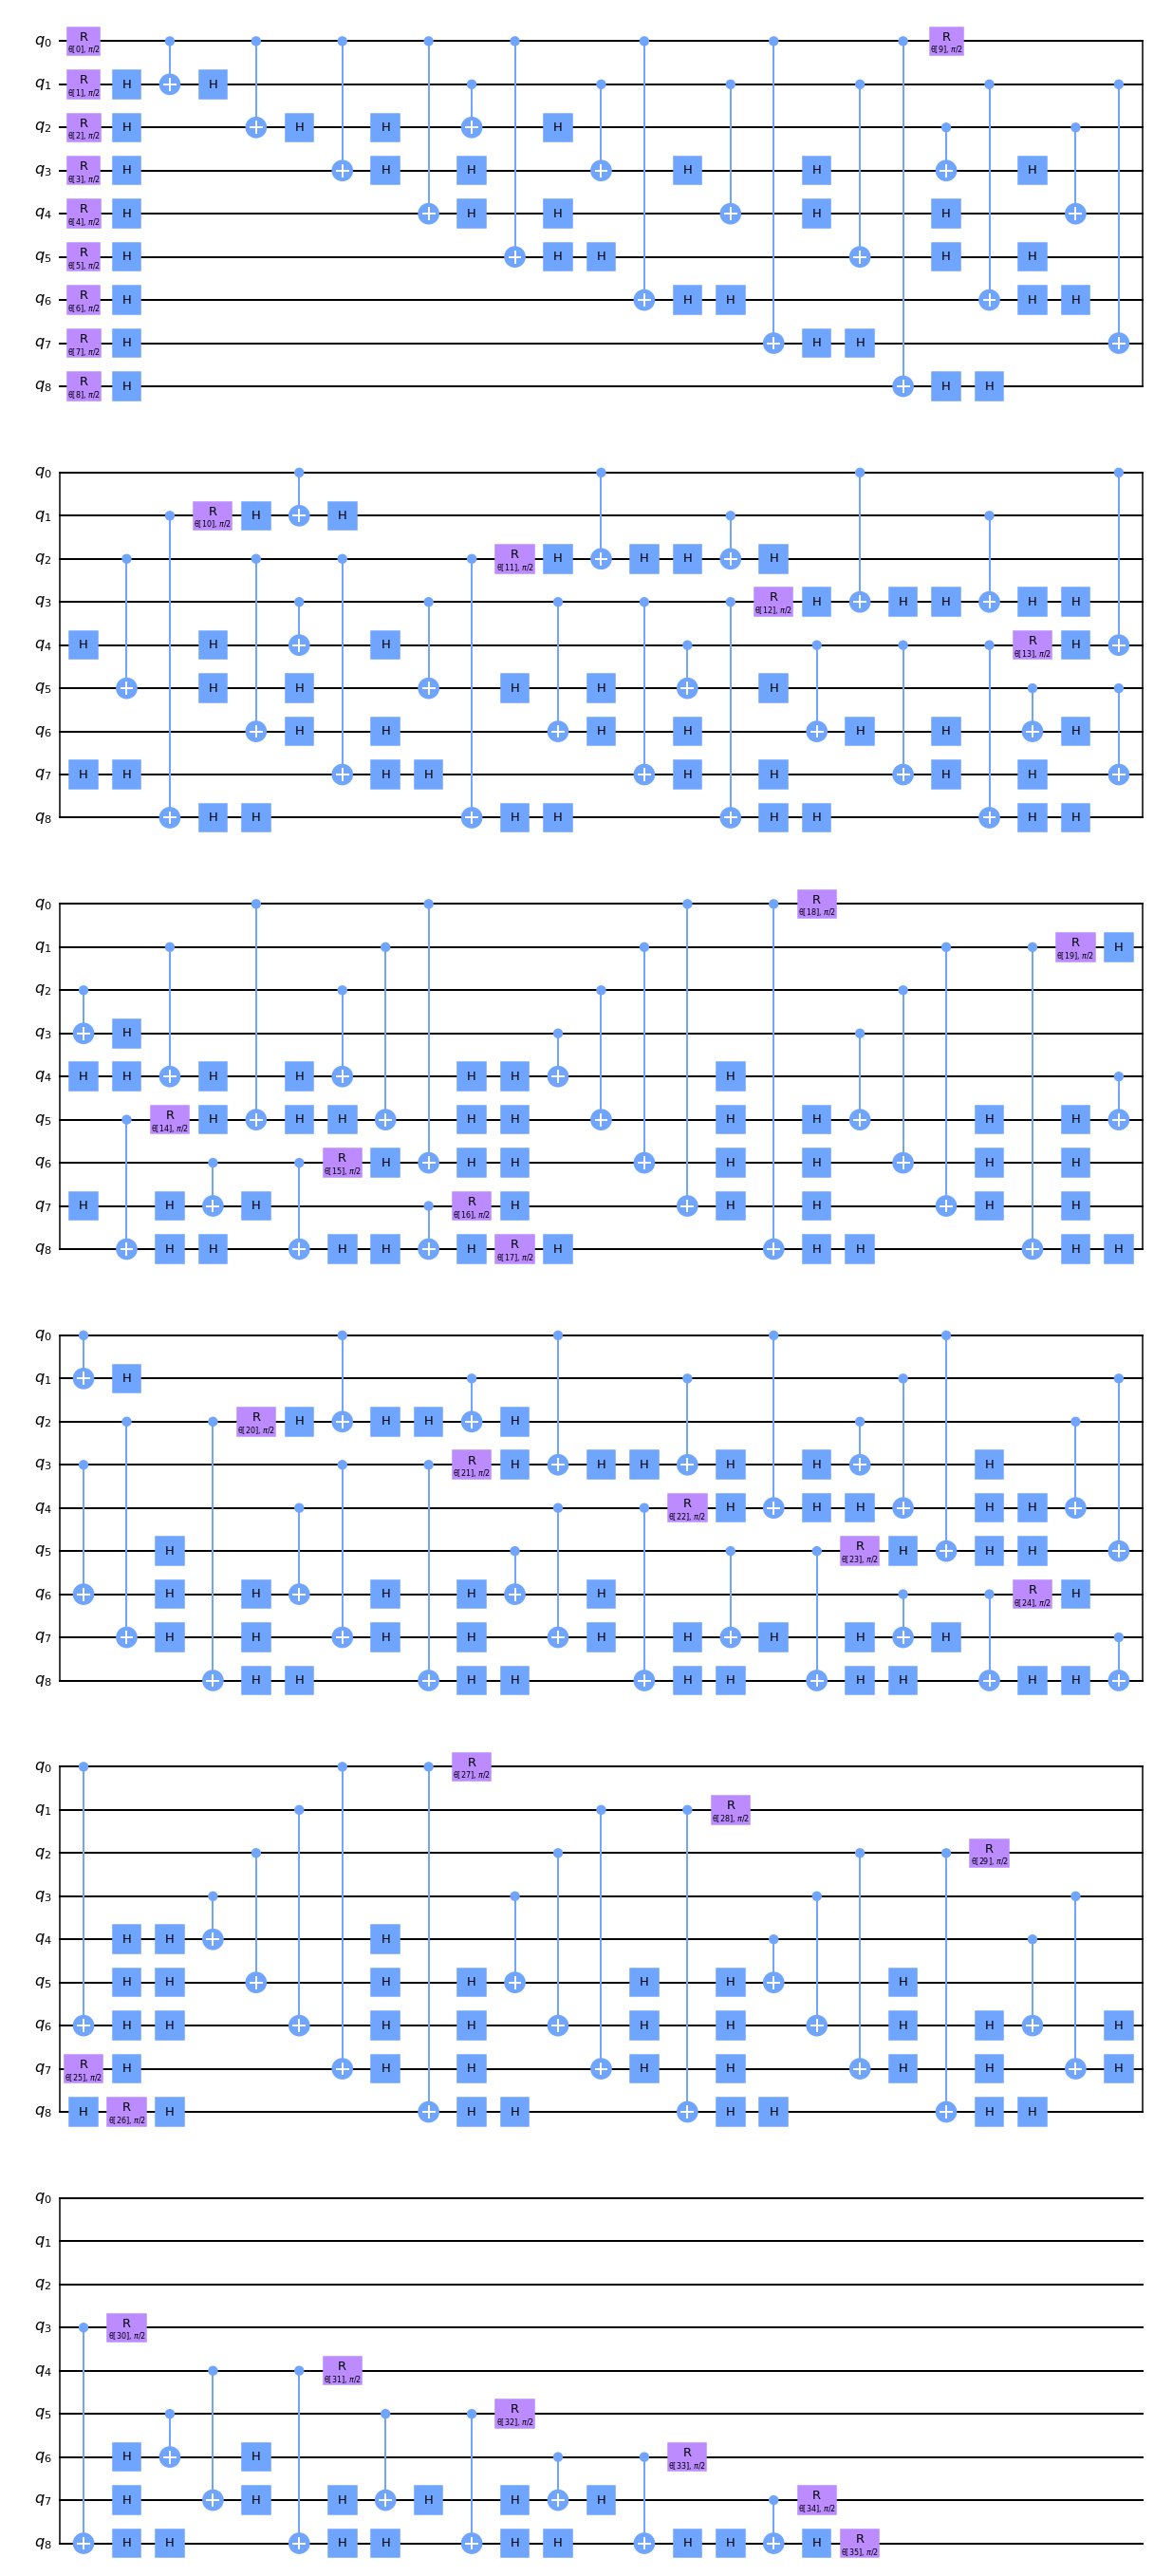

In [36]:

from qiskit import QuantumCircuit
qc = QuantumCircuit(qubitOp.num_qubits)
qc += ry
qc.decompose().draw('mpl')